In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle

import os
if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "torch"

In [2]:
with open(f'complete_pooling_metrics.pkl', 'rb') as f:
    complete_pooling_metrics = pickle.load(f)

with open(f'complete_pooling_trials_metrics.pkl', 'rb') as f:
    complete_pooling_trials_metrics = pickle.load(f)

with open(f'complete_pooling_subjects_metrics.pkl', 'rb') as f:
    complete_pooling_subjects_metrics = pickle.load(f)

with open(f'partial_pooling_global_metrics.pkl', 'rb') as f:
    partial_pooling_global_metrics = pickle.load(f)

with open(f'partial_pooling_local_metrics.pkl', 'rb') as f:
    partial_pooling_local_metrics = pickle.load(f)

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [55]:
pretty_param_names = [r'$\nu_p$', r'$\alpha_p$', r'$t_{0,p}$', r'$\beta_p$']
n_params = len(pretty_param_names)

pooling_models = [
    'No Pooling',  # trials
    'Complete Pooling',  # subjects
    'Partial Pooling' # local values
]
colors = ["#3498DB", "#27AE60", "#E67E22"]
fontsize = 11

metrics_names = list(complete_pooling_subjects_metrics.keys())
metrics_names_pretty = [r'NRMSE ($\circ$)', "", r'Calibration Error ($\blacktriangledown$)']

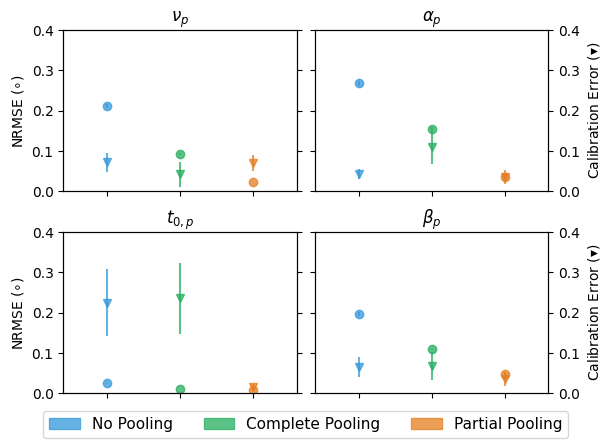

In [57]:
fig, axis = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 4), layout='constrained')
axis = axis.flatten()
for i in [0,2]:
    metric = metrics_names[i]
    for j in range(n_params):
        if i == 0:
            ax = axis[j]
            marker = 'o'
            ax.set_ylim(0, 0.4)
        else:
            ax = axis[j].twinx()
            marker = 'v'
            ax.set_ylim(0, 0.4)
            if j in [0, 2]:
                ax.set_yticks(ticks=np.linspace(0, 0.4, 5), labels=[])
            else:
                ax.set_yticks(ticks=np.linspace(0, 0.4, 5))
        values = [
            complete_pooling_trials_metrics[metric][j],
            complete_pooling_subjects_metrics[metric][j],
            partial_pooling_local_metrics[metric][j],
        ]
        yerrs = [
                complete_pooling_trials_metrics[metric+'-mad'][j],
                complete_pooling_subjects_metrics[metric+'-mad'][j],
                partial_pooling_local_metrics[metric+'-mad'][j],
            ]
        #ax.scatter(x=[1/4,2/4,3/4], y=values, color=colors, marker=marker, alpha=0.75)
        for x, v, v_err, c in zip([1/4,2/4,3/4], values, yerrs, colors):
            ax.errorbar(x=x, y=v, yerr=v_err, marker=marker, linestyle='', alpha=0.75, color=c)
        axis[j].set_title(pretty_param_names[j])
        ax.set_xticks(ticks=[1/4,2/4,3/4], labels=["", "", ""],
                      #labels=['NP', 'CP', 'PP'],
                      fontsize=fontsize)
        ax.set_xlim(0.1, 0.9)
        if (j in [0,2] and i == 0) or (j in [1, 3] and i == 2):
            ax.set_ylabel(metrics_names_pretty[i])
handles = [
    Patch(color=colors[i], label=pooling_models[i], alpha=0.75) for i in range(len(pooling_models))
]
fig.legend(handles=handles, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncols=3, fontsize=fontsize)
plt.savefig('plots/pooling_metrics.pdf', bbox_inches='tight')
plt.show()

# Model Visualization

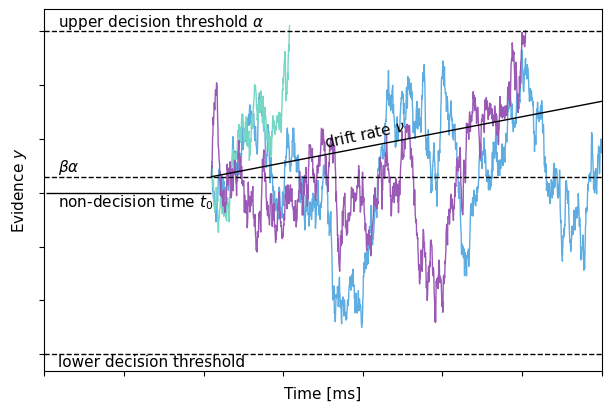

In [60]:
def simulate_ddm_path(nu, alpha, t0, beta, dt=1e-3, scale=1.0, max_time=3.0):
    y = beta * alpha
    rt = 0.0
    const = scale * np.sqrt(dt)
    ys = [y]
    ts = [0.0]
    while (alpha >= y >= 0) and rt <= max_time:
        z = np.random.randn()
        y += nu * dt + const * z
        rt += dt
        ys.append(y)
        ts.append(rt)
    c = 1.0 if y >= alpha else 0.0
    return np.array(ts) + t0, np.array(ys), c


# Parameters
np.random.seed(11)
alpha = 1.2
beta = 0.55
t0 = 0.6
dt = 1e-3
max_t = 2
x_label = 0.05*1000
colors = ["#5DADE2", "#76D7C4", "#9B59B6"]



# Re create the sample path figures
for nu in [0.2]:
    plt.figure(figsize=(6,4), layout='constrained')
    for i in range(3):
        ts, ys, c = simulate_ddm_path(nu=nu, alpha=alpha, t0=t0, beta=beta, dt=dt, max_time=max_t)
        plt.plot(ts*1000, ys, linewidth=1.0, color=colors[i])
    plt.axhline(0.0, linestyle="--", linewidth=1.0, color='black')
    plt.axhline(alpha, linestyle="--", linewidth=1.0, color='black')
    plt.axhline(beta*alpha, linestyle="--", linewidth=1.0, color='black')
    plt.hlines(alpha*0.5, xmin=x_label*0.1, xmax=t0*1000, linewidth=1.0, color='black')

    # deterministic drift line
    t_det = np.linspace(0, max_t, 500)
    y_det = beta * alpha + nu * t_det
    plt.plot((t_det + t0)*1000, y_det, color="black", linestyle="-", linewidth=1.0)

    #plt.title(f"DDM sample paths at drift rate nu = {nu}")
    plt.text(x_label, beta*alpha, r"$\beta\alpha$", va="bottom", ha="left", fontsize=fontsize)
    plt.text(x_label, alpha, r"upper decision threshold $\alpha$", va="bottom", ha="left", fontsize=fontsize)
    plt.text(x_label, 0, r"lower decision threshold", va="top", ha="left", fontsize=fontsize)
    plt.text(x_label, alpha*0.5, r"non-decision time $t_0$", va="top", ha="left", fontsize=fontsize)
    plt.text(t0*1000+400, beta*alpha+0.22, r"drift rate $\nu$", va="top", ha="left", rotation=12, fontsize=fontsize)
    plt.xlim(0, max_t*1000)
    plt.xticks(np.linspace(0, max_t*1000, 8), "")
    plt.yticks(np.linspace(0, alpha, 7), "")
    plt.xlabel(r"Time [ms]", fontsize=fontsize)
    plt.ylabel(r"Evidence $y$", fontsize=fontsize)
    plt.savefig('plots/model_visualization_ddm.pdf', bbox_inches='tight')
    plt.show()